In [1]:
from FeatExtract import get_bvp_features

In [2]:
import numpy as np

def generate_asymmetric_windows(signal, fs, window_size=8, hop_size=1):
    """
    Generates asymmetric windows near boundaries.
    
    Returns:
        windows: list of np.arrays
        centers: list of center times (seconds)
        durations: list of actual window durations (seconds)
    """
    N = len(signal)
    T = N / fs

    half = window_size / 2
    windows = []
    centers = []
    durations = []

    t = 0.0
    while t <= T:
        start_t = max(0, t - half)
        end_t   = min(T, t + half)

        start_i = int(start_t * fs)
        end_i   = int(end_t * fs)

        if end_i - start_i >= fs * 3:  # minimum 3s to avoid garbage HRV
            win = signal[start_i:end_i]
            windows.append(win)
            centers.append(t)
            durations.append(end_t - start_t)

        t += hop_size

    return windows, np.array(centers), np.array(durations)


In [3]:
import numpy as np
from scipy.signal import find_peaks, czt
from scipy.stats import linregress
from itertools import permutations


def compute_bvp_arousal_features(bvp, fs,
                                 fmin=0.66,
                                 fmax=3.0,
                                 n_czt_bins=512):
    """
    Compute arousal-related features from short POS-based BVP signals
    using Chirp Z-Transform (CZT) for spectral analysis.

    Parameters
    ----------
    bvp : np.ndarray
        1D Blood Volume Pulse signal
    fs : float
        Sampling frequency (Hz)
    fmin, fmax : float
        Frequency band of interest (Hz)
    n_czt_bins : int
        Number of CZT frequency bins

    Returns
    -------
    features : dict
        Dictionary of extracted features
    """

    features = {}
    bvp = np.asarray(bvp, dtype=float)

    if len(bvp) < fs * 5:
        # Too short to be meaningful
        for k in [
            "mean_hr", "hr_slope", "rmssd", "ibi_cv",
            "dom_freq", "peak_power_ratio", "spec_entropy",
            "freq_variance", "hr_snr",
            "amp_mean", "amp_std",
            "sample_entropy", "perm_entropy",
            "peak_success_ratio"
        ]:
            features[k] = np.nan
        return features

    # Remove DC
    bvp -= np.mean(bvp)

    # --------------------------------------------------
    # 1. Peak detection & IBI
    # --------------------------------------------------
    min_dist = int(0.4 * fs)  # ~150 bpm upper bound
    peaks, _ = find_peaks(bvp, distance=min_dist)

    if len(peaks) < 3:
        for k in features:
            features[k] = np.nan
        return features

    ibi = np.diff(peaks) / fs
    hr = 60.0 / ibi

    # --------------------------------------------------
    # 2. HR / IBI features
    # --------------------------------------------------
    features["mean_hr"] = np.mean(hr)

    t = np.arange(len(hr))
    features["hr_slope"] = linregress(t, hr).slope

    diff_ibi = np.diff(ibi)
    features["rmssd"] = (
        np.sqrt(np.mean(diff_ibi ** 2)) if len(diff_ibi) > 0 else np.nan
    )

    features["ibi_cv"] = np.std(ibi) / np.mean(ibi)

    # --------------------------------------------------
    # 3. CZT-based spectral features
    # --------------------------------------------------
    N = len(bvp)

    w = np.exp(-1j * 2 * np.pi * (fmax - fmin) / (n_czt_bins * fs))
    a = np.exp(1j * 2 * np.pi * fmin / fs)

    spectrum = czt(bvp, n_czt_bins, w, a)
    power = np.abs(spectrum) ** 2
    freqs = np.linspace(fmin, fmax, n_czt_bins)

    total_power = np.sum(power)

    if total_power > 0:
        idx_peak = np.argmax(power)
        dom_freq = freqs[idx_peak]

        features["dom_freq"] = dom_freq
        features["peak_power_ratio"] = power[idx_peak] / total_power

        p_norm = power / total_power
        features["spec_entropy"] = -np.sum(
            p_norm * np.log2(p_norm + 1e-12)
        )

        features["freq_variance"] = np.sum(
            power * (freqs - dom_freq) ** 2
        ) / total_power

        features["hr_snr"] = np.max(power) / (np.mean(power) + 1e-12)

    else:
        features["dom_freq"] = np.nan
        features["peak_power_ratio"] = np.nan
        features["spec_entropy"] = np.nan
        features["freq_variance"] = np.nan
        features["hr_snr"] = np.nan

    # --------------------------------------------------
    # 4. Pulse amplitude features
    # --------------------------------------------------
    troughs, _ = find_peaks(-bvp, distance=min_dist)
    n_beats = min(len(peaks), len(troughs))

    if n_beats > 0:
        amp = bvp[peaks[:n_beats]] - bvp[troughs[:n_beats]]
        features["amp_mean"] = np.mean(amp)
        features["amp_std"] = np.std(amp)
    else:
        features["amp_mean"] = np.nan
        features["amp_std"] = np.nan

    # --------------------------------------------------
    # 5. Sample entropy
    # --------------------------------------------------
    def sample_entropy(x, m=2, r=0.2):
        x = np.asarray(x)
        r *= np.std(x)
        N = len(x)

        def _phi(m):
            x_m = np.array([x[i:i + m] for i in range(N - m)])
            C = np.sum(
                np.max(
                    np.abs(x_m[:, None] - x_m[None, :]), axis=2
                ) <= r,
                axis=0
            ) - 1
            return np.sum(C) / ((N - m) * (N - m - 1))

        return -np.log(_phi(m + 1) / _phi(m))

    try:
        features["sample_entropy"] = sample_entropy(bvp)
    except Exception:
        features["sample_entropy"] = np.nan

    # --------------------------------------------------
    # 6. Permutation entropy
    # --------------------------------------------------
    def permutation_entropy(x, order=3, delay=1):
        x = np.asarray(x)
        perms = list(permutations(range(order)))
        counts = np.zeros(len(perms))

        for i in range(len(x) - delay * (order - 1)):
            pattern = x[i:i + delay * order:delay]
            idx = perms.index(tuple(np.argsort(pattern)))
            counts[idx] += 1

        p = counts / np.sum(counts)
        return -np.sum(p * np.log2(p + 1e-12))

    try:
        features["perm_entropy"] = permutation_entropy(bvp)
    except Exception:
        features["perm_entropy"] = np.nan

    # --------------------------------------------------
    # 7. Signal quality
    # --------------------------------------------------
    expected_beats = len(bvp) / fs * (features["mean_hr"] / 60.0)
    features["peak_success_ratio"] = (
        len(peaks) / expected_beats if expected_beats > 0 else np.nan
    )

    return features


In [4]:
def extract_window_features(windows, fs):
    X = []
    valid_idx = []

    for i, w in enumerate(windows):
        feats = compute_bvp_arousal_features(w, fs)
        if feats is None or len(feats) == 0:
            continue
        X.append(list(feats.values()))
        valid_idx.append(i)

    return np.array(X), np.array(valid_idx)


In [5]:
def predict_probabilities(clf, X):
    return clf.predict_proba(X)


In [6]:
# IMPORTANT: adjust if your class ordering differs
# clf.classes_ should confirm this
Q1, Q3, Q7, Q9 = 0, 1, 2, 3


In [7]:
def quadrant_probs_to_arousal_valence(probs):
    arousal  = probs[:, Q1] + probs[:, Q3]   # ↑A
    valence  = probs[:, Q3] + probs[:, Q9]   # ↑V
    return arousal, valence


In [8]:
from scipy.ndimage import gaussian_filter1d

def smooth_signal(x, sigma=2):
    return gaussian_filter1d(x, sigma=sigma)


In [9]:
def apply_duration_weighting(signal, durations, full_window=8):
    weights = np.clip(durations / full_window, 0.5, 1.0)
    return signal * weights


In [10]:
!pip install ruptures


In [11]:
import ruptures as rpt

def detect_change_points(signal, penalty=5):
    signal = signal.reshape(-1, 1)
    algo = rpt.Pelt(model="rbf").fit(signal)
    return algo.predict(pen=penalty)


In [12]:
def analyze_bvp_emotion_dynamics(
    bvp_signal,
    fs,
    clf,
    window_size=8,
    hop_size=1,
    smooth_sigma=2
):
    # 1. Windowing
    windows, centers, durations = generate_asymmetric_windows(
        bvp_signal, fs, window_size, hop_size
    )

    # 2. Features
    X, valid_idx = extract_window_features(windows, fs)
    centers = centers[valid_idx]
    durations = durations[valid_idx]

    # 3. Probabilities
    probs = predict_probabilities(clf, X)

    # 4. Arousal / Valence
    arousal, valence = quadrant_probs_to_arousal_valence(probs)

    # 5. Reliability weighting
    arousal = apply_duration_weighting(arousal, durations)
    valence = apply_duration_weighting(valence, durations)

    # 6. Smoothing
    arousal_s = smooth_signal(arousal, smooth_sigma)
    valence_s = smooth_signal(valence, smooth_sigma)

    # 7. Change detection (arousal is more reliable)
    change_points = detect_change_points(arousal_s)

    return {
        "time": centers,
        "arousal": arousal_s,
        "valence": valence_s,
        "raw_probs": probs,
        "change_points": change_points
    }


In [13]:
import numpy as np
from scipy.signal import find_peaks, czt
from scipy.stats import linregress
from itertools import permutations


def compute_bvp_arousal_features(bvp, fs,
                                 fmin=0.66,
                                 fmax=3.0,
                                 n_czt_bins=512):
    """
    Compute arousal-related features from short POS-based BVP signals
    using Chirp Z-Transform (CZT) for spectral analysis.

    Parameters
    ----------
    bvp : np.ndarray
        1D Blood Volume Pulse signal
    fs : float
        Sampling frequency (Hz)
    fmin, fmax : float
        Frequency band of interest (Hz)
    n_czt_bins : int
        Number of CZT frequency bins

    Returns
    -------
    features : dict
        Dictionary of extracted features
    """

    features = {}
    bvp = np.asarray(bvp, dtype=float)

    if len(bvp) < fs * 5:
        # Too short to be meaningful
        for k in [
            "mean_hr", "hr_slope", "rmssd", "ibi_cv",
            "dom_freq", "peak_power_ratio", "spec_entropy",
            "freq_variance", "hr_snr",
            "amp_mean", "amp_std",
            "sample_entropy", "perm_entropy",
            "peak_success_ratio"
        ]:
            features[k] = np.nan
        return features

    # Remove DC
    bvp -= np.mean(bvp)

    # --------------------------------------------------
    # 1. Peak detection & IBI
    # --------------------------------------------------
    min_dist = int(0.4 * fs)  # ~150 bpm upper bound
    peaks, _ = find_peaks(bvp, distance=min_dist)

    if len(peaks) < 3:
        for k in features:
            features[k] = np.nan
        return features

    ibi = np.diff(peaks) / fs
    hr = 60.0 / ibi

    # --------------------------------------------------
    # 2. HR / IBI features
    # --------------------------------------------------
    features["mean_hr"] = np.mean(hr)

    t = np.arange(len(hr))
    features["hr_slope"] = linregress(t, hr).slope

    diff_ibi = np.diff(ibi)
    features["rmssd"] = (
        np.sqrt(np.mean(diff_ibi ** 2)) if len(diff_ibi) > 0 else np.nan
    )

    features["ibi_cv"] = np.std(ibi) / np.mean(ibi)

    # --------------------------------------------------
    # 3. CZT-based spectral features
    # --------------------------------------------------
    N = len(bvp)

    w = np.exp(-1j * 2 * np.pi * (fmax - fmin) / (n_czt_bins * fs))
    a = np.exp(1j * 2 * np.pi * fmin / fs)

    spectrum = czt(bvp, n_czt_bins, w, a)
    power = np.abs(spectrum) ** 2
    freqs = np.linspace(fmin, fmax, n_czt_bins)

    total_power = np.sum(power)

    if total_power > 0:
        idx_peak = np.argmax(power)
        dom_freq = freqs[idx_peak]

        features["dom_freq"] = dom_freq
        features["peak_power_ratio"] = power[idx_peak] / total_power

        p_norm = power / total_power
        features["spec_entropy"] = -np.sum(
            p_norm * np.log2(p_norm + 1e-12)
        )

        features["freq_variance"] = np.sum(
            power * (freqs - dom_freq) ** 2
        ) / total_power

        features["hr_snr"] = np.max(power) / (np.mean(power) + 1e-12)

    else:
        features["dom_freq"] = np.nan
        features["peak_power_ratio"] = np.nan
        features["spec_entropy"] = np.nan
        features["freq_variance"] = np.nan
        features["hr_snr"] = np.nan

    # --------------------------------------------------
    # 4. Pulse amplitude features
    # --------------------------------------------------
    troughs, _ = find_peaks(-bvp, distance=min_dist)
    n_beats = min(len(peaks), len(troughs))

    if n_beats > 0:
        amp = bvp[peaks[:n_beats]] - bvp[troughs[:n_beats]]
        features["amp_mean"] = np.mean(amp)
        features["amp_std"] = np.std(amp)
    else:
        features["amp_mean"] = np.nan
        features["amp_std"] = np.nan

    # --------------------------------------------------
    # 5. Sample entropy
    # --------------------------------------------------
    def sample_entropy(x, m=2, r=0.2):
        x = np.asarray(x)
        r *= np.std(x)
        N = len(x)

        def _phi(m):
            x_m = np.array([x[i:i + m] for i in range(N - m)])
            C = np.sum(
                np.max(
                    np.abs(x_m[:, None] - x_m[None, :]), axis=2
                ) <= r,
                axis=0
            ) - 1
            return np.sum(C) / ((N - m) * (N - m - 1))

        return -np.log(_phi(m + 1) / _phi(m))

    try:
        features["sample_entropy"] = sample_entropy(bvp)
    except Exception:
        features["sample_entropy"] = np.nan

    # --------------------------------------------------
    # 6. Permutation entropy
    # --------------------------------------------------
    def permutation_entropy(x, order=3, delay=1):
        x = np.asarray(x)
        perms = list(permutations(range(order)))
        counts = np.zeros(len(perms))

        for i in range(len(x) - delay * (order - 1)):
            pattern = x[i:i + delay * order:delay]
            idx = perms.index(tuple(np.argsort(pattern)))
            counts[idx] += 1

        p = counts / np.sum(counts)
        return -np.sum(p * np.log2(p + 1e-12))

    try:
        features["perm_entropy"] = permutation_entropy(bvp)
    except Exception:
        features["perm_entropy"] = np.nan

    # --------------------------------------------------
    # 7. Signal quality
    # --------------------------------------------------
    expected_beats = len(bvp) / fs * (features["mean_hr"] / 60.0)
    features["peak_success_ratio"] = (
        len(peaks) / expected_beats if expected_beats > 0 else np.nan
    )

    return features


In [14]:
base_path_video = "BVPs"

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

paths = [
    "Q1_1",
    "Q1_2",
    # "Q2_1",
    # "Q2_2",
    "Q3_1",
    "Q3_2",
    # "Q4_1",
    # "Q4_2",
    # "Q5_1",
    # "Q5_2",
    # "Q6_1",
    # "Q6_2",
    "Q7_1",
    "Q7_2",
    # "Q8_1",
    # "Q8_2",
    "Q9_1",
    "Q9_2"
]

patients = list(range(1, 62))
patients.remove(23)

#patients = expressive
class BVP:
    def __init__(self, patient, path, signal, features):
        self.patient = patient
        self.path = path
        self.signal = signal
        self.features = features

In [16]:
fs = 60

BVPs = []

for patient in patients:

    for path in paths:

        if [patient, path] in failed_masks:
            print(f"Skipping Patient_{patient}, {path}")
            continue

        data = np.load(f"../{base_path_video}/Patient_{patient}/{path}.npy")

        #t_start, t_end = getattr(Timestamps, path)

        #data_cut = cut_bvp(data, t_start, t_end, fs)

        #bvp = BVP(patient, path, data_cut, [])

        bvp = BVP(patient, path, data, [])

        BVPs.append(bvp)

        #print(f"Patient_{patient}, {path}: {data.shape}")

print(f"Loaded {len(BVPs)} BVP signals")

Skipping Patient_2, Q1_1
Skipping Patient_52, Q7_2
Loaded 478 BVP signals


In [17]:
fs = 60  # sampling rate

valid = []
failed = []

failed_masks = [
    [2, "Q1_1"],
    [52, "Q7_2"],
    [53, "Q4_2"]
]

for bvp in BVPs:  # use a copy to safely remove items

    print(f"Computing Features for Patient_{bvp.patient}...", end="\r", flush=True)
    
    try:
        # Use the new windowed feature extraction
        feats = compute_bvp_arousal_features(
            bvp.signal,
            fs,
        )

        if feats is None or feats == []:
            print(f"Failed: Patient_{bvp.patient}, {bvp.path}")
            failed.append(f"Patient_{bvp.patient}, {bvp.path}")
            BVPs.remove(bvp)  # remove problematic signal
        else:
            bvp.features = feats
            valid.append(f"Patient_{bvp.patient}, {bvp.path}")

    except Exception as e:
        print(f"Error for Patient_{bvp.patient}, {bvp.path}: {e}")
        failed.append(f"Patient_{bvp.patient}, {bvp.path}")
        BVPs.remove(bvp)

print(f"Extracted features for {len(valid)} videos")

# Example inspection
if valid:
    print(list(BVPs[0].features.items()))


Extracted features for 478 videos...
[('mean_hr', np.float64(92.67175147884798)), ('hr_slope', np.float64(-0.18722620300888415)), ('rmssd', np.float64(0.21440089070590135)), ('ibi_cv', np.float64(0.26113481903988517)), ('dom_freq', np.float64(1.1591389432485322)), ('peak_power_ratio', np.float64(0.03442903244127362)), ('spec_entropy', np.float64(7.076777467820204)), ('freq_variance', np.float64(0.2080585340041526)), ('hr_snr', np.float64(17.627664609931983)), ('amp_mean', np.float64(0.24989149000154537)), ('amp_std', np.float64(0.11648765336562995)), ('sample_entropy', np.float64(0.47257829173557264)), ('perm_entropy', np.float64(1.4628079769958475)), ('peak_success_ratio', np.float64(0.9343615492425701))]


In [18]:
label_map = {
    "Q1": "Q1: ↑Arousal ↓Val",
    "Q2": "Q2: ↑Arousal -Val",
    "Q3": "Q3: ↑Arousal ↑Val",
    "Q4": "Q4: -Arousal ↓Val",
    "Q5": "Q5: -Arousal -Val",
    "Q6": "Q6: -Arousal ↑Val",
    "Q7": "Q7: ↓Arousal ↓Val",
    "Q8": "Q8: ↓Arousal -Val",
    "Q9": "Q9: ↓Arousal ↑Val",
}

def get_label(path):
    q = path.split("_")[0]  # "Q3_2" → "Q3"
    return label_map[q]



In [19]:
import numpy as np

X = []
y = []

for bvp in BVPs:
    if bvp is None or bvp.features == []:
        print("Error: Patient", bvp.patient, bvp.path)
        continue

    feat_values = list(bvp.features.values())
    X.append(feat_values)
    y.append(get_label(bvp.path))
    

X = np.array(X)
y = np.array(y)

print(X.shape, y.shape)
print(np.unique(y, return_counts=True))
print("Example of data: ", X[0])


(478, 14) (478,)
(array(['Q1: ↑Arousal ↓Val', 'Q3: ↑Arousal ↑Val', 'Q7: ↓Arousal ↓Val',
       'Q9: ↓Arousal ↑Val'], dtype='<U17'), array([119, 120, 119, 120]))
Example of data:  [ 9.26717515e+01 -1.87226203e-01  2.14400891e-01  2.61134819e-01
  1.15913894e+00  3.44290324e-02  7.07677747e+00  2.08058534e-01
  1.76276646e+01  2.49891490e-01  1.16487653e-01  4.72578292e-01
  1.46280798e+00  9.34361549e-01]


LEARNING

In [20]:
# Random Split

type = "Random"

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,      # important for emotions
    random_state=42
)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("Example of data: ", X_train[0])


(334, 14) (334,)
(144, 14) (144,)
Example of data:  [ 9.76585374e+01 -7.29781607e-02  1.40668339e-01  1.32698991e-01
  7.97377691e-01  4.09183901e-02  6.74691037e+00  5.66747292e-01
  2.09502157e+01  1.76360624e-01  6.79312783e-02  4.39646204e-01
  1.53005227e+00  9.70082541e-01]


In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        class_weight="balanced"
    ))
])



In [22]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

X = []
y = []
groups = []

for bvp in BVPs:
    if bvp is None or bvp.features == []:
        print(f"Skipping Patient_{bvp.patient} {bvp.path}")
        continue

    X.append(list(bvp.features.values()))
    y.append(get_label(bvp.path))
    groups.append(bvp.patient)

X = np.array(X)
y = np.array(y)
groups = np.array(groups)

In [23]:
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score

cv = StratifiedGroupKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scores = cross_val_score(
    pipe,
    X,
    y,
    groups=groups,
    cv=cv,
    scoring="f1_macro"
)

print("F1 macro:", scores.mean(), "±", scores.std())


F1 macro: 0.34401808077118445 ± 0.00628873895302286


In [24]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=200, random_state=42))])

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = pipe.predict(X_test)

clasif_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(clasif_report)
print(conf_matrix)


                   precision    recall  f1-score   support

Q1: ↑Arousal ↓Val       0.38      0.31      0.34        36
Q3: ↑Arousal ↑Val       0.22      0.19      0.21        36
Q7: ↓Arousal ↓Val       0.39      0.58      0.47        36
Q9: ↓Arousal ↑Val       0.24      0.19      0.22        36

         accuracy                           0.32       144
        macro avg       0.31      0.32      0.31       144
     weighted avg       0.31      0.32      0.31       144

[[11  9  8  8]
 [ 8  7  9 12]
 [ 3 10 21  2]
 [ 7  6 16  7]]


In [28]:
results = analyze_bvp_emotion_dynamics(BVPs[0].signal, fs = 60, clf = pipe)

print(results)

{'time': array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22.]), 'arousal': array([0.34586367, 0.37799053, 0.43214468, 0.49099774, 0.5356174 ,
       0.55377113, 0.54683872, 0.52898182, 0.51821716, 0.52656838,
       0.55581272, 0.59960932, 0.64832642, 0.69236782, 0.7234818 ,
       0.73620236, 0.72895432, 0.70283406, 0.65974854, 0.60296701,
       0.53975002, 0.48298652, 0.44871785]), 'valence': array([0.40655247, 0.43629817, 0.48188289, 0.52752971, 0.5659775 ,
       0.59768671, 0.62404213, 0.64405322, 0.65619615, 0.66122005,
       0.66287642, 0.6657243 , 0.67194429, 0.68063793, 0.68976615,
       0.69716847, 0.69903313, 0.68899005, 0.66100875, 0.61437563,
       0.55655694, 0.50229094, 0.46902137]), 'raw_probs': array([[0.18 , 0.27 , 0.305, 0.245],
       [0.32 , 0.27 , 0.01 , 0.4  ],
       [0.235, 0.305, 0.03 , 0.43 ],
       [0.265, 0.26 , 0.02 , 0.455],
       [0.435, 0.285, 0.1  , 0.18 ],
       [0.35 ,

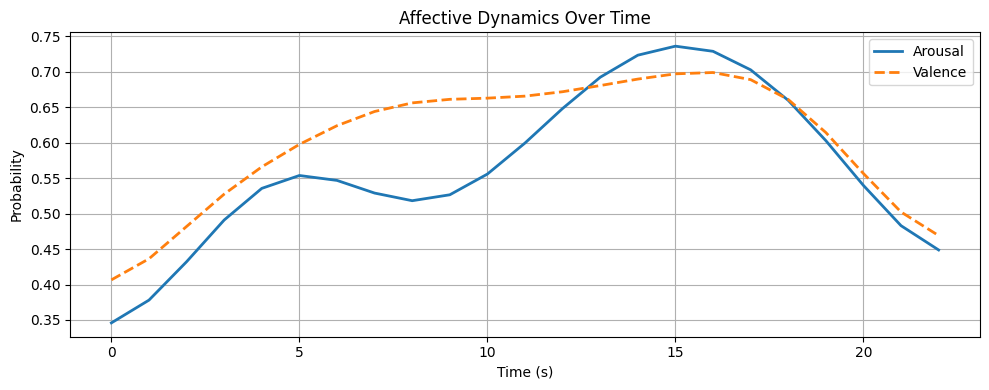

In [29]:
import matplotlib.pyplot as plt

res = results  # your dict

t = res["time"]
arousal = res["arousal"]
valence = res["valence"]

plt.figure(figsize=(10, 4))
plt.plot(t, arousal, label="Arousal", linewidth=2)
plt.plot(t, valence, label="Valence", linewidth=2, linestyle="--")

plt.xlabel("Time (s)")
plt.ylabel("Probability")
plt.title("Affective Dynamics Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


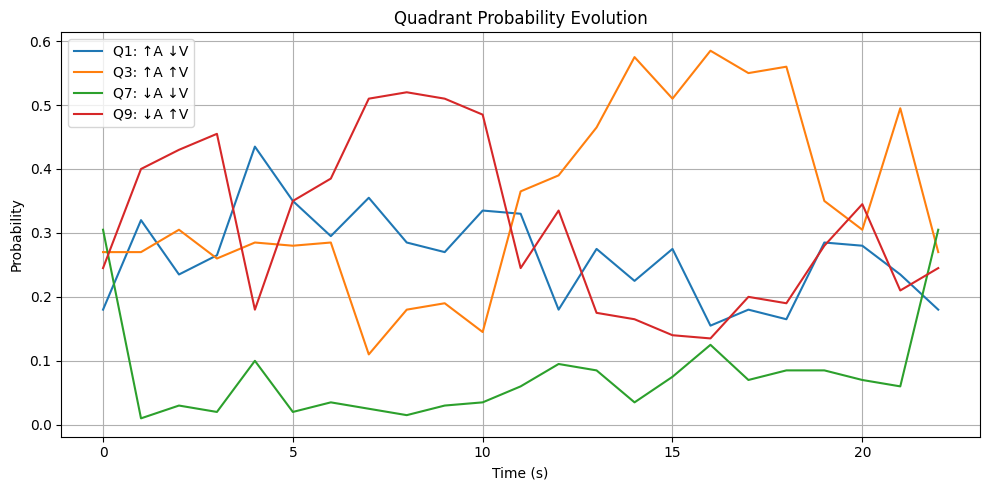

In [30]:
probs = res["raw_probs"]

labels = [
    "Q1: ↑A ↓V",
    "Q3: ↑A ↑V",
    "Q7: ↓A ↓V",
    "Q9: ↓A ↑V"
]

plt.figure(figsize=(10, 5))

for i, label in enumerate(labels):
    plt.plot(t, probs[:, i], label=label)

plt.xlabel("Time (s)")
plt.ylabel("Probability")
plt.title("Quadrant Probability Evolution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


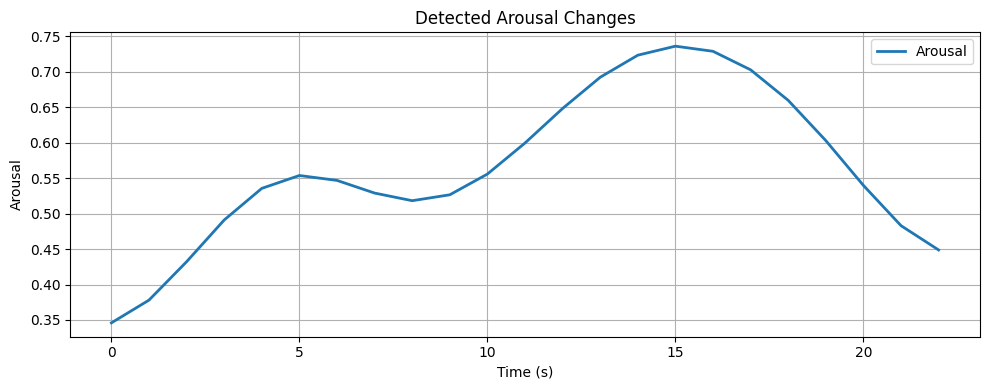

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(t, arousal, label="Arousal", linewidth=2)

for cp in res["change_points"]:
    if cp < len(t):
        plt.axvline(t[cp-1], color="red", linestyle="--", alpha=0.8)

plt.xlabel("Time (s)")
plt.ylabel("Arousal")
plt.title("Detected Arousal Changes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [32]:
pipe.classes_

array(['Q1: ↑Arousal ↓Val', 'Q3: ↑Arousal ↑Val', 'Q7: ↓Arousal ↓Val',
       'Q9: ↓Arousal ↑Val'], dtype='<U17')